# Enso Simulation / Scenario Analysis Framework

1) Data Cleaning ENSO and ADF/Stationarity test
2) Fitting ARIMA model (test for d)
3) Fourier Decomposition
4) Fit corresponding ARIMAX model with Fourier as exogenous
4) Create Forecast and Scenario's for next 5 years

## ENSO Timeseries Cleaning and Stationarity

In [2]:
import pandas as pd
import numpy as np
# Load the dataset
enso_df = pd.read_csv('../Data/enso_mei_long.csv')
# Display the first few rows of the dataframe and check for missing values
display(enso_df.tail(), enso_df.isnull().sum())
#remove NaN MEI rows
enso_df = enso_df.dropna()
enso_df.tail()


,Year,Month,MEI
535,2023,Aug,0.43
536,2023,Sep,0.59
537,2023,Oct,NaN
538,2023,Nov,NaN
539,2023,Dec,NaN


Year     0
Month    0
MEI      3
dtype: int64

,Year,Month,MEI
532,2023,May,-0.14
533,2023,Jun,0.23
534,2023,Jul,0.25
535,2023,Aug,0.43
536,2023,Sep,0.59


Adjust dataset to correct timeseries format

In [3]:
# Convert the 'Year' and 'Month' into a datetime object and set it as the index
enso_df['Date'] = pd.to_datetime(enso_df['Year'].astype(str) + ' ' + enso_df['Month'], format="%Y %b")
enso_df.set_index('Date', inplace=True)

# Drop the original 'Year' and 'Month' columns 
enso_df.drop(['Year', 'Month'], axis=1, inplace=True)

# Ensure the data is sorted in chronological order
enso_df.sort_index(inplace=True)
enso_df.index = pd.DatetimeIndex(enso_df.index.values, freq=enso_df.index.inferred_freq)

# Check the dataframe structure now
display(enso_df.head(), enso_df.tail())


,MEI
1979-01-01,0.47
1979-02-01,0.27
1979-03-01,-0.04
1979-04-01,0.26
1979-05-01,0.35


,MEI
2023-05-01,-0.14
2023-06-01,0.23
2023-07-01,0.25
2023-08-01,0.43
2023-09-01,0.59


Check ACF and PACF of timeseries

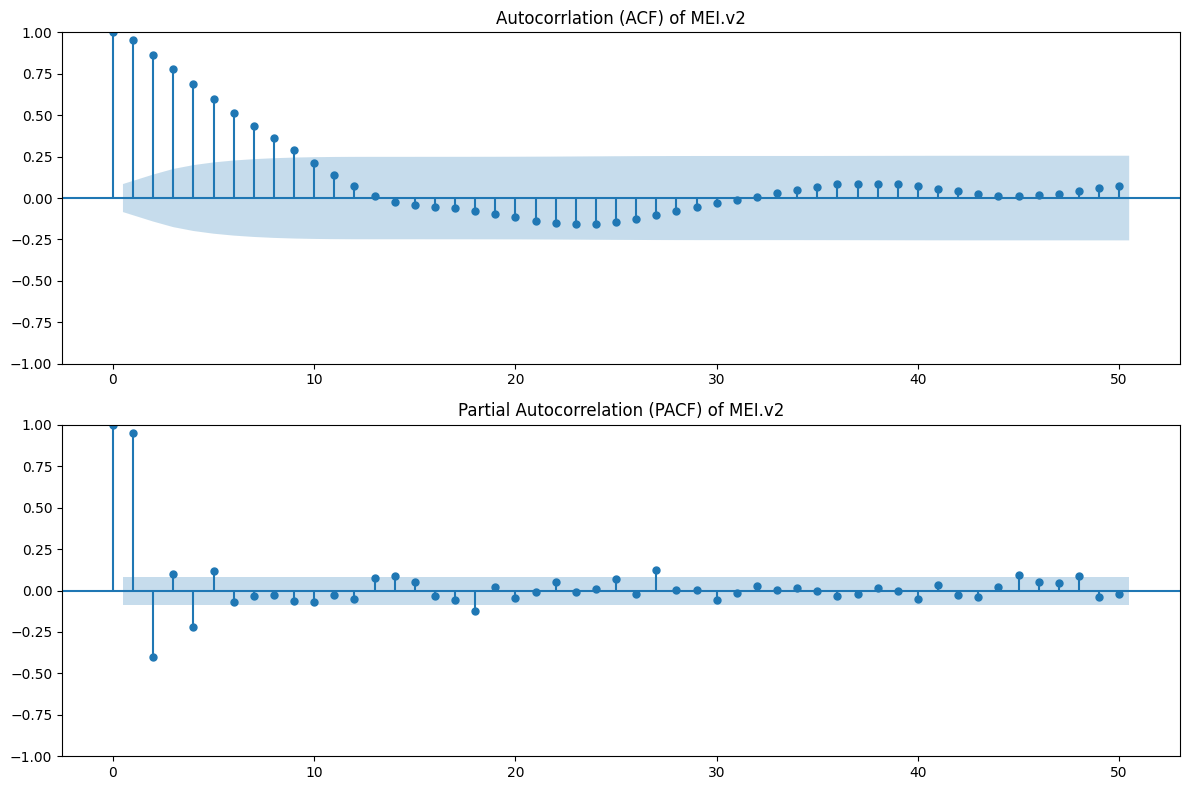

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the Autocorrelation Function (ACF)
plot_acf(enso_df['MEI'], lags=50, ax=ax1, title= "Autocorrlation (ACF) of MEI.v2")
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(enso_df['MEI'], lags=50, ax=ax2, title= "Partial Autocorrelation (PACF) of MEI.v2")
plt.savefig('../Plots/ACF_PACF.png')
plt.tight_layout()
plt.show()


## ADF

In [5]:
#ADF test on the MEI data
from statsmodels.tsa.stattools import adfuller
# Run the ADF test on the MEI data
result1 = adfuller(enso_df['MEI'])
# Print the p-value
adf_diff = enso_df['MEI'].diff().dropna()
result2 = adfuller(adf_diff)
result1, result2

((-5.082583134276866,
  1.51946635794005e-05,
  17,
  519,
  {'1%': -3.4430126933746767,
   '5%': -2.8671249839002764,
   '10%': -2.569744590233924},
  109.2037623392024),
 (-8.536360162782925,
  1.005509999665642e-13,
  13,
  522,
  {'1%': -3.4429395567097445,
   '5%': -2.8670927932098063,
   '10%': -2.569727435298953},
  129.9433407369453))

## KPSS

In [6]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kwargs):
    """
    Perform KPSS test on the given time series and return the test statistic and p-value.
    """œ
    statistic, p_value, _, critical_values = kpss(series, **kwargs)
    return statistic, p_value, critical_values

# Initialize variables
differenced_series = enso_df['MEI']
stationary = False
max_diff = 10
diff_count = 0

kpss_results = []

while not stationary and diff_count < max_diff:
    # Apply differencing
    differenced_series = differenced_series.diff().dropna()

    # Perform KPSS test
    statistic, p_value, critical_values = kpss_test(differenced_series)
    kpss_results.append((diff_count + 1, statistic, p_value, critical_values))

    # Check if the series is stationary
    if p_value > 0.05:
        stationary = True

    diff_count += 1
#Returns how many differencing till stationary
# kpss_results[-1], stationary, diff_count
display(kpss_test(enso_df['MEI']))
display(kpss_test(enso_df['MEI'], regression='c'))

SyntaxError: invalid syntax (363297535.py, line 6)

From above we can conclude d = 1 is enough

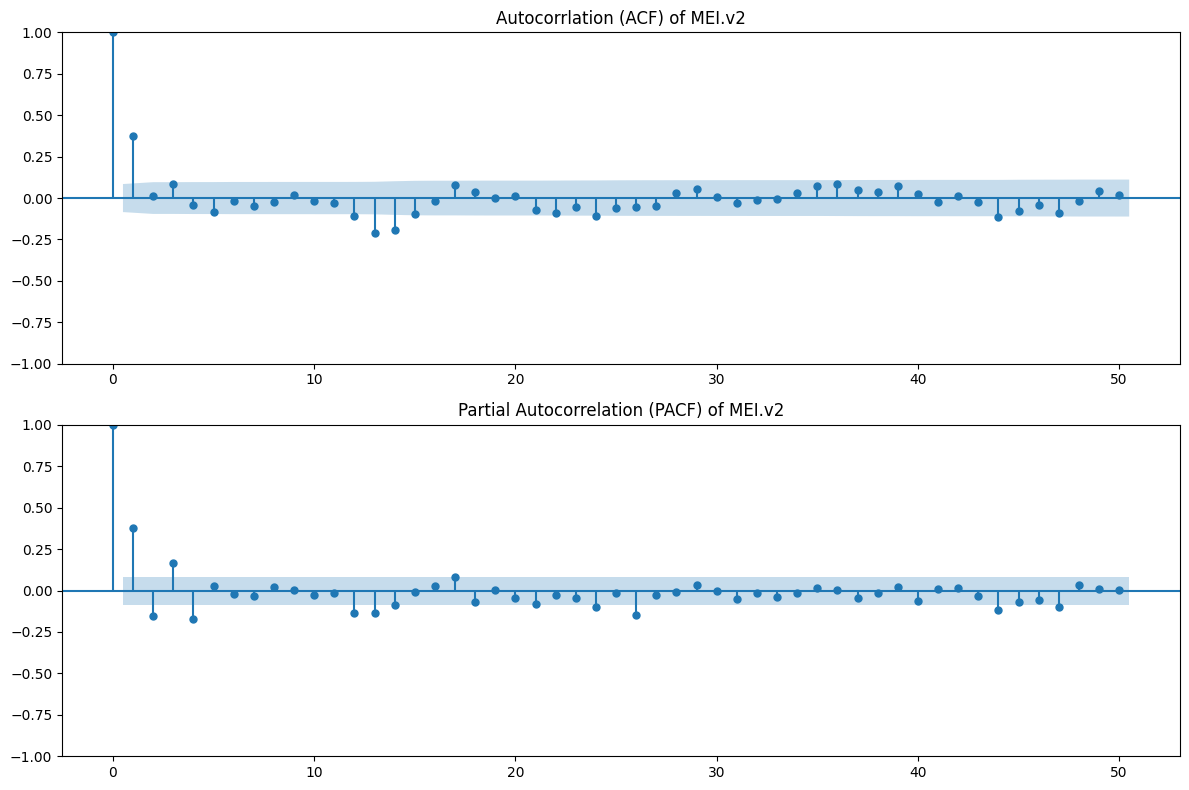

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

# Differencing the series once to handle non-stationarity
differenced_series = enso_df['MEI'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the Autocorrelation Function (ACF)
plot_acf(differenced_series, lags=50, ax=ax1, title= "Autocorrlation (ACF) of MEI.v2")
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(differenced_series, lags=50, ax=ax2, title= "Partial Autocorrelation (PACF) of MEI.v2")
plt.savefig('../Plots/diffACF_PACF.png')
plt.tight_layout()
plt.show()

- The ACF shows a slow decay, which indicates a non-stationary series or a series with long-term correlations.
- The PACF has a spike at lag 1 and lag 2, suggesting AR(1) or AR(2) model might be needed.
Since the series is normalized and stationary we do not need $d$ = 1, this means that we can look at models ARIMA(p,0,q) where 0 <= p,q <= 2 

## Fourier Decomposition

Fourier decomposition involves transforming the time series into the frequency domain using the Fourier Transform. This allows us to identify dominant cycles in the data which can be related to seasonal effects.

Apply the Fourier Transform to the MEI time series.
- Identify the dominant frequencies (which correspond to the strongest seasonal patterns).
- Use these dominant frequencies to construct a series of sine and cosine terms that model the seasonal pattern.
- These sine and cosine terms will later be used as exogenous variables in the ARIMAX model.

,Frequency,Amplitude
4,0.007449,153.864183
12,0.022346,133.572696
8,0.014898,116.754668
15,0.027933,99.788434
10,0.018622,99.419709
1,0.001862,93.567986
18,0.033520,89.675907
30,0.055866,81.549433
11,0.020484,75.180320
19,0.035382,49.670009


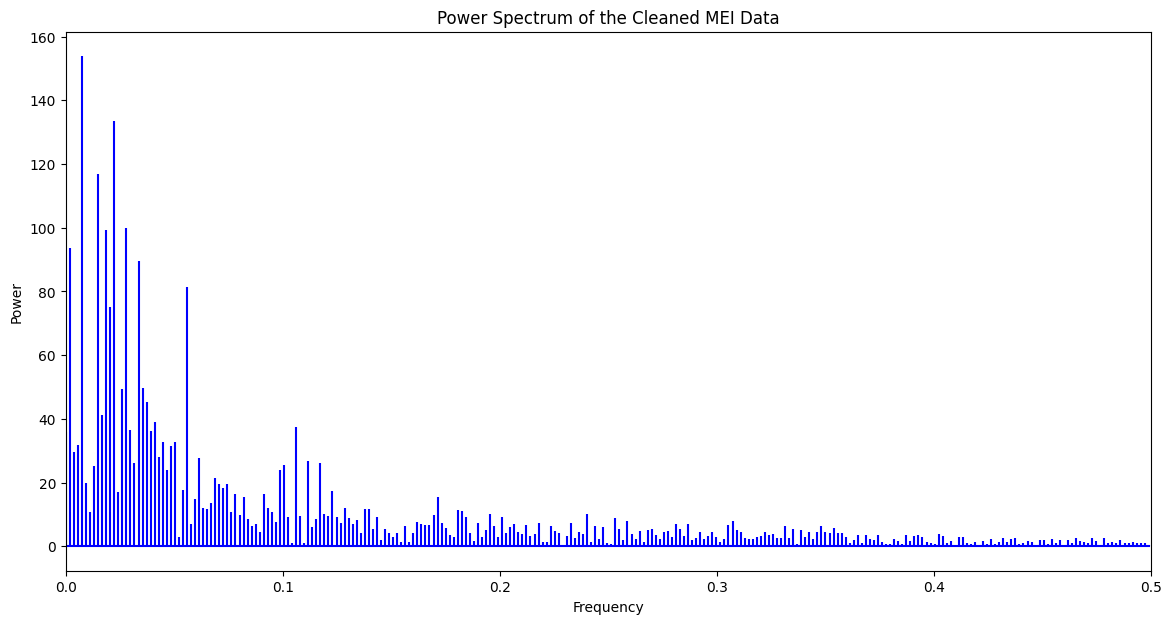

In [7]:
import numpy as np
from scipy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
N = enso_df.shape[0]
T = 1.0  # assuming monthly data, so the unit is 'months'
# Compute the fast Fourier Transform (rfft) of the MEI time series
yf = rfft(enso_df['MEI'].values)
# Generate the sample frequencies
xf = rfftfreq(N, T)
# Create a dataframe of frequencies and their corresponding amplitudes
fft_df = pd.DataFrame({'Frequency': xf, 'Amplitude': np.abs(yf)})
fft_df_sorted = fft_df.sort_values(by='Amplitude', ascending=False)
# Display the dominant frequencies
display(fft_df_sorted.head(10))

spectrum = np.abs(yf)
plt.figure(figsize=(14, 7))
plt.stem(xf, spectrum, 'b', markerfmt=" ", basefmt="-b")
plt.title('Power Spectrum of the Cleaned MEI Data')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xlim(0, 0.5)  # Only plot the positive frequencies
plt.savefig('../Plots/fft.png')
plt.show()

The power spectrum plot shows the various frequencies present in the ENSO data and their relative power. 

Peaks in this spectrum represent dominant frequencies that could correspond to seasonal or cyclical patterns.



Frequencies in cycles per month, we take a few with the highest amplitudes to construct the sine and cosine terms. We select top 5 frequencies to als not overfit.

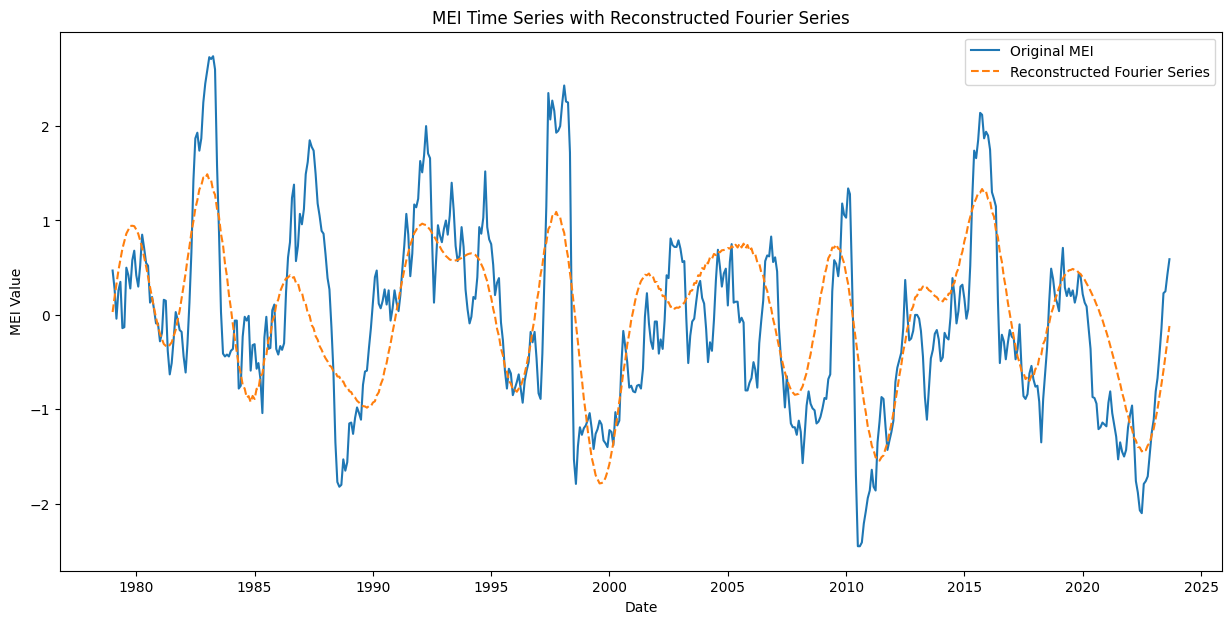

In [8]:
# Select the top 5 frequencies, No 0 since this is overall trend
top_frequencies = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5)
top_indices = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5).index

# Create a new series of Fourier coefficients where all but the top components are set to zero
filtered_fft_values = np.zeros_like(yf)
for i in top_indices:
    filtered_fft_values[i] = yf[i]
    filtered_fft_values[-i] = yf[-i]  # Include the complex conjugate for inverse FFT (imaginary numbers are mirrored and should be added)

# Perform the inverse FFT to reconstruct the time series using the top components/feqs
reconstructed_series = irfft(filtered_fft_values, n=N)

# Plot the original MEI time series and the reconstructed Fourier series
plt.figure(figsize=(15, 7))
plt.plot(enso_df.index, enso_df['MEI'], label='Original MEI')
plt.plot(enso_df.index, reconstructed_series, label='Reconstructed Fourier Series', linestyle='--')
plt.legend()
plt.title('MEI Time Series with Reconstructed Fourier Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.savefig('../Plots/MEI_Fourier.png')
plt.show()

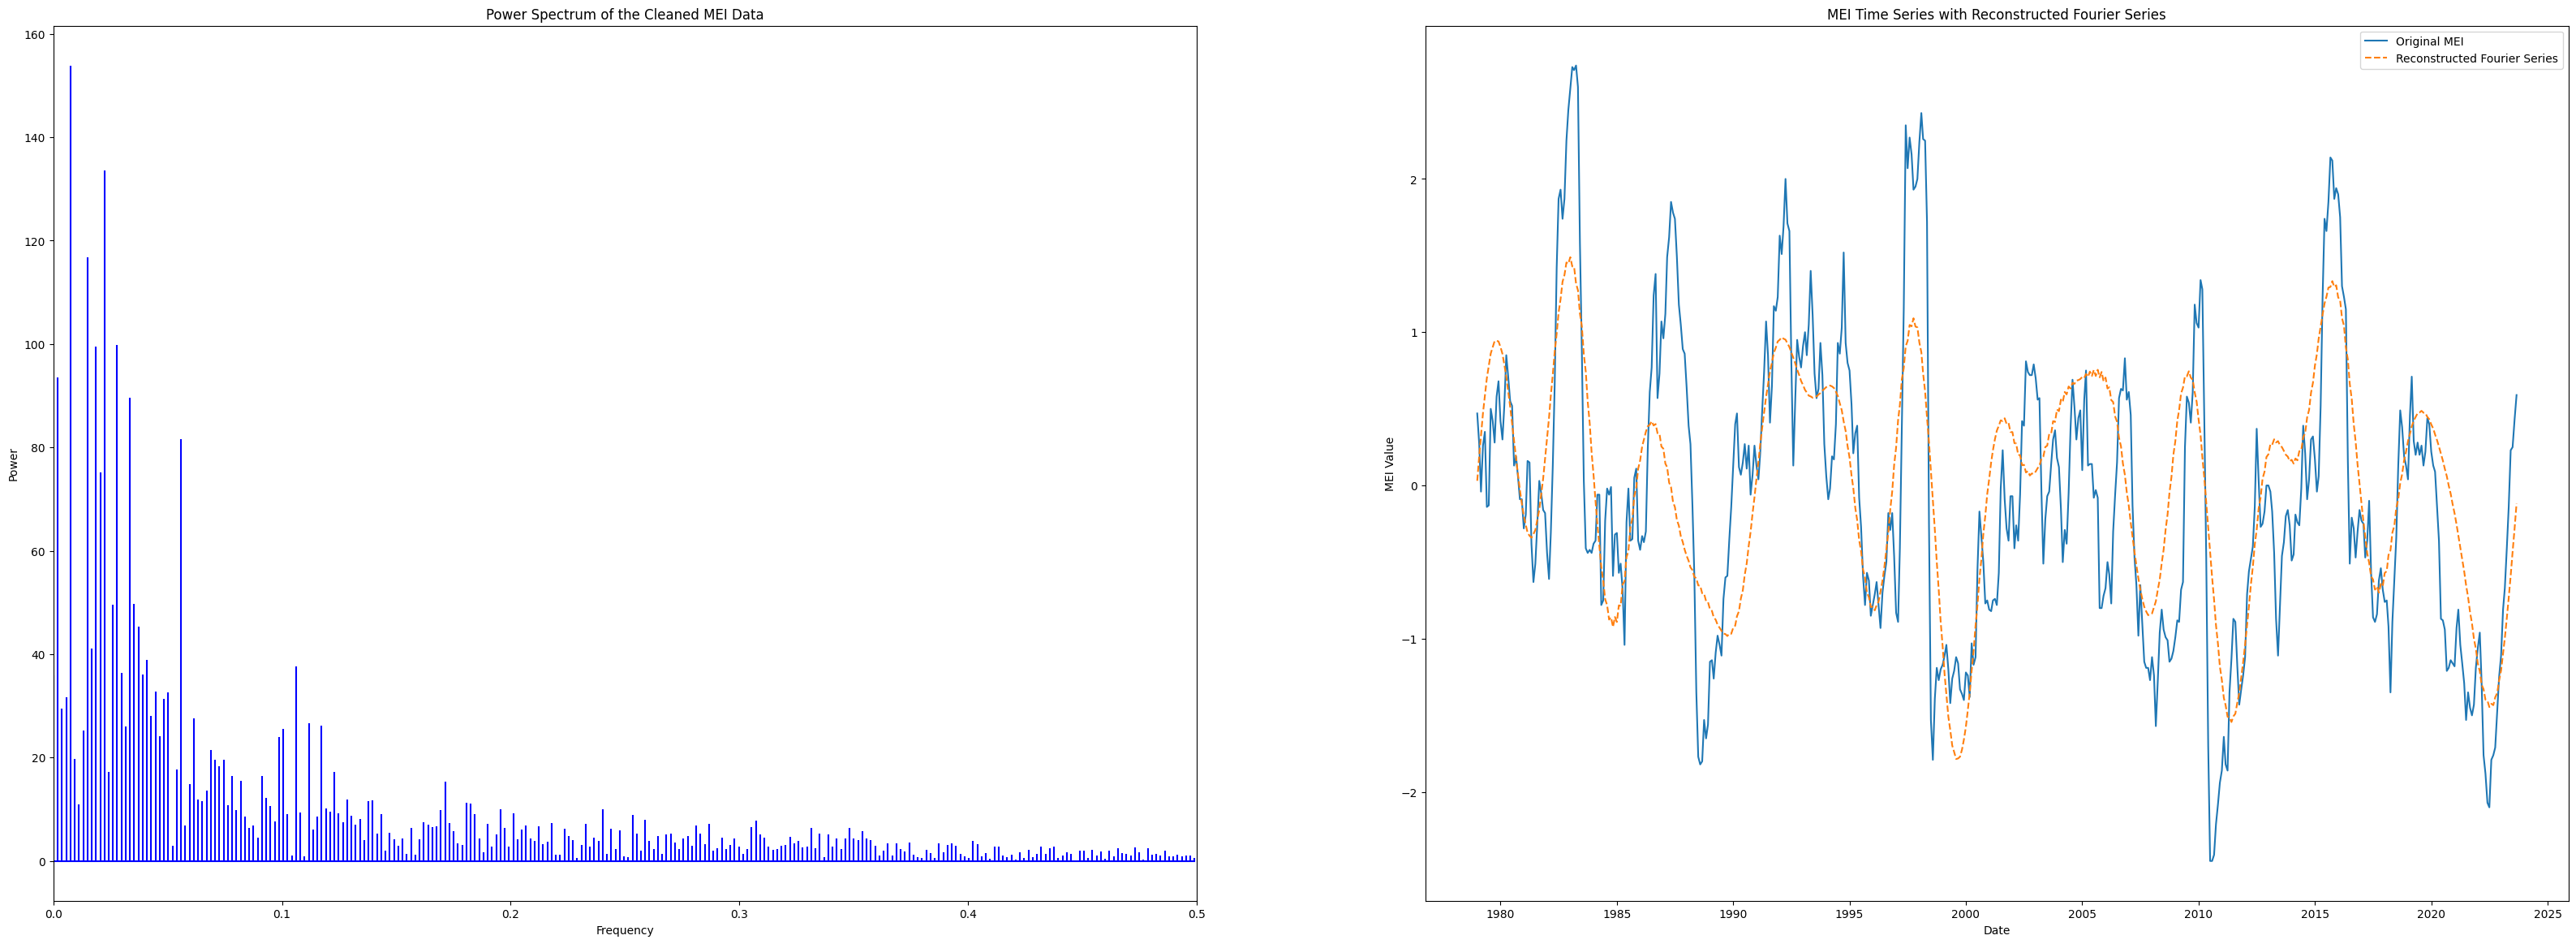

In [9]:
#Plot side by side above
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 14))
ax1.stem(xf, spectrum, 'b', markerfmt=" ", basefmt="-b")
ax1.set_title('Power Spectrum of the Cleaned MEI Data')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
ax1.set_xlim(0, 0.5)  # Only plot the positive frequencies
ax2.plot(enso_df.index, enso_df['MEI'], label='Original MEI')
ax2.plot(enso_df.index, reconstructed_series, label='Reconstructed Fourier Series', linestyle='--')
ax2.legend()
ax2.set_title('MEI Time Series with Reconstructed Fourier Series')
ax2.set_xlabel('Date')
ax2.set_ylabel('MEI Value')
plt.savefig('../Plots/fft_fourier.png')
plt.show()

### Fourier Residuals

Just to check how this looks

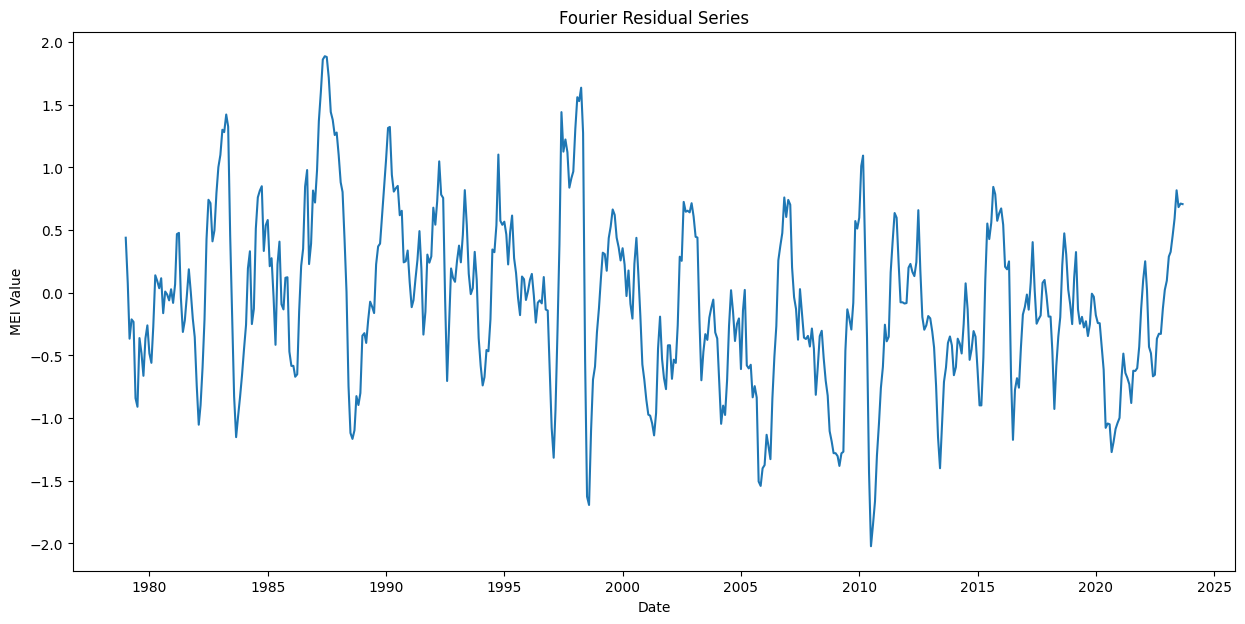

In [ ]:
#Fourier residual plot
fourier_residuals = enso_df['MEI'] - reconstructed_series
#plot Fourier residual series
plt.figure(figsize=(15, 7))
plt.plot(enso_df.index, fourier_residuals)
plt.title('Fourier Residual Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.savefig('../Plots/fourier_residuals.png')
plt.show()

## ARIMA(X) model fitting

The next steps are to:

- Fit an ARIMA model to the MEI data.
- Incorporate the sine and cosine terms as exogenous variables to fit an ARIMAX model.

### ARIMA Model selection
- Look at ACF and PACF
- Look at AIC and BIC

### ARIMA(p,0,q) p <= 2 and q <= 2

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

arima_orders = []
# [(3,1,0), (3,1,1), (3,1,2), (3,1,3), (2,1,3)]
#for loop to create arima_orders p, 1, q for p in range(1, 5) for q in range(1, 4)]
for p in range(1, 5):
    for q in range(1, 5):
        arima_orders.append((p, 1, q))


# (1,1,0), (1,1,1), (2, 1, 1), (1, 1, 2), (2, 1, 2), (2,1,0), 
# Initialize a dictionary to store results
arima_results = {}

# Fit the ARIMA models and store the results
for order in arima_orders:
    #ignore warnings
    model = SARIMAX(enso_df['MEI'], order=order)
    results = model.fit()

    # Jarque-Bera test
    jb_test_stat, jb_p_value, _, _ = jarque_bera(results.resid)

    # Ljung-Box test
    # lb_test_stat, lb_p_value = acorr_ljungbox(results.resid, lags=[10], return_df=False)[0]

    arima_results[order] = {
        'AIC': results.aic,
        'BIC': results.bic,
        'Log Likelihood': results.llf,
        'JB Test Statistic': jb_test_stat,
        'JB p-value': jb_p_value
        # 'LB Test Statistic (lag 10)': lb_test_stat,
        # 'LB p-value (lag 10)': lb_p_value
    }

# Convert the results to a DataFrame for easy comparison
arima_results_df = pd.DataFrame(arima_results).T

# Identify the best models based on various criteria
best_aic_model = arima_results_df['AIC'].idxmin()
best_bic_model = arima_results_df['BIC'].idxmin()
best_log_lik_model = arima_results_df['Log Likelihood'].idxmax()

# Display the results in a nicely formatted table
display(arima_results_df)
display("Best Model based on AIC:", best_aic_model)
display("Best Model based on BIC:", best_bic_model)
display("Best Model based on Log Likelihood:", best_log_lik_model)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31376D-01    |proj g|=  6.39396D-02

At iterate    5    f=  1.28440D-01    |proj g|=  3.11421D-02

At iterate   10    f=  1.27557D-01    |proj g|=  8.60034D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.600D-06   1.276D-01
  F =  0.12755686276630582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.24162D-01    |proj g|=  1.12102D-02

At iterate   15    f=  1.22944D-01    |proj g|=  3.61627D-02

At iterate   20    f=  1.22658D-01    |proj g|=  2.89724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     27      1     0     0   7.880D-06   1.227D-01
  F =  0.12265789483046106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53459D-01    |proj g|=  4.45177D+00

At iter

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.21918D-01    |proj g|=  2.12521D-03

At iterate   20    f=  1.21913D-01    |proj g|=  2.19599D-03

At iterate   25    f=  1.21880D-01    |proj g|=  7.33108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   3.169D-05   1.219D-01
  F =  0.12187969638136377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23212D-01    |proj g|=  2.60415D-02

At iter

 This problem is unconstrained.
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   45    f=  1.17962D-01    |proj g|=  2.06597D-02

At iterate   50    f=  1.17685D-01    |proj g|=  4.82777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.828D-03   1.177D-01
  F =  0.11768473608644542     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28181D-01    |proj g|=  5.33886D-02

At iterate    5    f=  1.25928D-01    |proj g|=  2.66472D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.20349D-01    |proj g|=  4.00487D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     30      1     0     0   4.005D-05   1.203D-01
  F =  0.12034938584593961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22939D-01    |proj g|=  2.13137D-02

At iterate    5    f=  1.22572D-01    |proj g|=  1.23931D-02

At iterate   10    f=  1.22184D-01    |proj g|=  9.07475D-03

At iter

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22396D-01    |proj g|=  2.03328D-02

At iterate    5    f=  1.21936D-01    |proj g|=  1.51881D-03

At iterate   10    f=  1.21923D-01    |proj g|=  2.08048D-03

At iterate   15    f=  1.21856D-01    |proj g|=  1.41670D-03

At iterate   20    f=  1.21849D-01    |proj g|=  1.59517D-03

At iterate   25    f=  1.21733D-01    |proj g|=  3.69625D-02

At iterate   30    f=  1.20208D-01    |proj g|=  1.73367D-02

At iterate   35    f=  1.18980D-01    |proj g|=  2.81810D-02

At iterate   40    f=  1.18067D-01    |proj g|=  3.01987D-02

At iterate   45    f=  1.17601D-01    |proj g|=  7.25525D-03

At iterate   50    f=  1.17582D-01    |proj g|=  2.74439D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19589D-01    |proj g|=  3.80980D-03

At iterate   10    f=  1.19429D-01    |proj g|=  1.36768D-02

At iterate   15    f=  1.19290D-01    |proj g|=  3.05986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   5.162D-05   1.193D-01
  F =  0.11929015395117197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19352D-01    |proj g|=  1.99335D-02

At iter

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.18410D-01    |proj g|=  1.49617D-02

At iterate   15    f=  1.18091D-01    |proj g|=  2.44029D-02

At iterate   20    f=  1.13043D-01    |proj g|=  1.34088D-01

At iterate   25    f=  1.02677D-01    |proj g|=  2.72569D-02

At iterate   30    f=  1.01109D-01    |proj g|=  5.69871D-02

At iterate   35    f=  9.90742D-02    |proj g|=  7.74674D-03

At iterate   40    f=  9.89958D-02    |proj g|=  2.32823D-03

At iterate   45    f=  9.89860D-02    |proj g|=  9.38416D-04

At iterate   50    f=  9.89838D-02    |proj g|=  9.71463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC         BIC  Log Likelihood  JB Test Statistic    JB p-value
1 1 1  142.996071  155.848473      -68.498035         291.524032  4.970050e-64
    2  144.695076  161.831612      -68.347538         286.659701  5.657661e-63
    3  143.922967  165.343638      -66.961483         271.094841  1.356760e-59
    4  143.734579  169.439384      -65.867290         286.784480  5.315466e-63
2 1 1  144.242569  161.379106      -68.121285         277.718700  4.944821e-61
    2  145.409139  166.829810      -67.704570         275.718755  1.344105e-60
    3  142.898794  168.603599      -65.449397         267.451899  8.386060e-59
    4  140.393407  170.382346      -63.196703         227.290111  4.411431e-50
3 1 1  142.414196  163.834867      -66.207098         282.041754  5.693919e-62
    2  141.255240  166.960045      -64.627620         261.512234  1.634330e-57
    3  140.355823  170.344763      -63.177912         224.574324  1.715162e-49
    4  142.283481  176.556555      -63.141741         217.951374  4.703925e-48
4 1 1  140.117625  165.822430      -64.058813         257.860424  1.014659e-56
    2  142.093843  172.082782      -64.046921         256.951012  1.598809e-56
    3  119.898805  154.171879      -51.949403         152.383934  8.132968e-34
    4  124.308602  162.865809      -53.154301         141.825714  1.595649e-31

'Best Model based on AIC:'

(4, 1, 3)

'Best Model based on BIC:'

(4, 1, 3)

'Best Model based on Log Likelihood:'

(4, 1, 3)

- ARIMA(2,0,2) seems to be the best fitting model
- However following parsimony we will choose the ARIMA(1,0,1) model since the improvements over this model do not seem to be good enough and best BIC

### ARIMA(1,1,1)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31376D-01    |proj g|=  6.39396D-02

At iterate    5    f=  1.28440D-01    |proj g|=  3.11421D-02

At iterate   10    f=  1.27557D-01    |proj g|=  8.60034D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.600D-06   1.276D-01
  F =  0.12755686276630582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


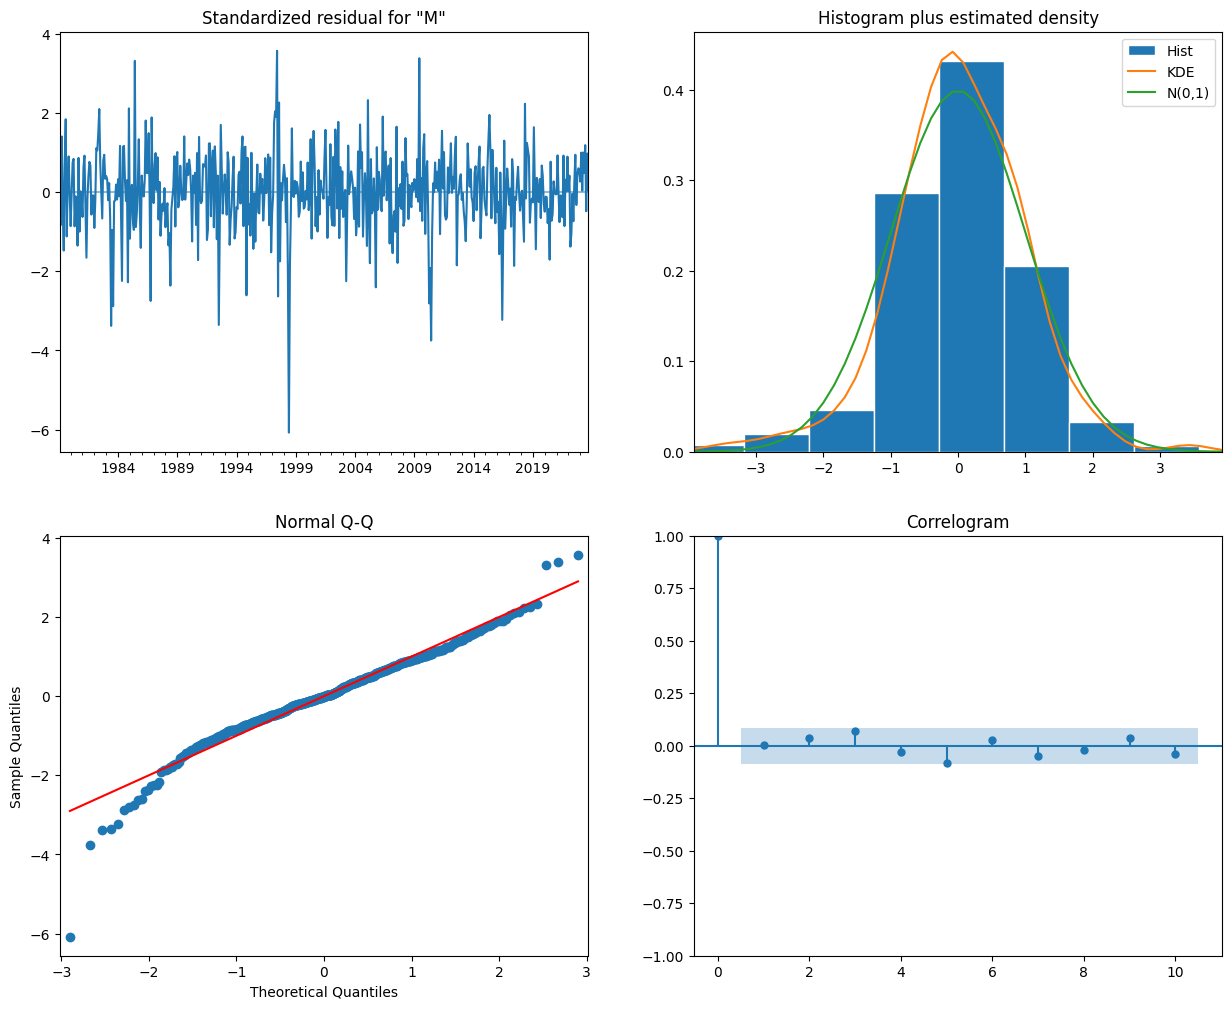

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -68.498
Date:                Thu, 16 Nov 2023   AIC                            142.996
Time:                        17:08:56   BIC                            155.848
Sample:                    01-01-1979   HQIC                           148.024
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1583      0.073     -2.179      0.029      -0.301      -0.016
ma.L1          0.6454      0.062     10.436      0.000       0.524       0.767
sigma2         0.0755      0.003     25.321      0.000       0.070       0.081
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               297.51
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.62
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Fit an ARIMA(1,0,1) model
arima_model_111 = SARIMAX(enso_df['MEI'], order=(1, 1, 1))
arima_result_111 = arima_model_111.fit()

# Plot the diagnostics for the ARIMA(1,0,1) model
fig = arima_result_111.plot_diagnostics(figsize=(15, 12))
plt.savefig('../Plots/ARIMA_111.png')
plt.show()

# Return the summary of the new model as well
arima_result_101_summary = arima_result_111.summary()
display(arima_result_101_summary)

- AR1 and MA1 significant
- LL improved from -120 => -58
- AIC and BIC also decreased 247 -> 124
- L-B test suggest no significant autocorrelation and residuals independently distributed.
- J-B no normality within residuals. 
- ACF shows better behaviour than no MA1 component.  

### ARIMA(2,1,2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26706D-01    |proj g|=  2.87892D-02

At iterate    5    f=  1.26192D-01    |proj g|=  6.98327D-03

At iterate   10    f=  1.26127D-01    |proj g|=  2.39735D-03

At iterate   15    f=  1.26079D-01    |proj g|=  2.41416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   3.218D-06   1.261D-01
  F =  0.12607927303020677     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


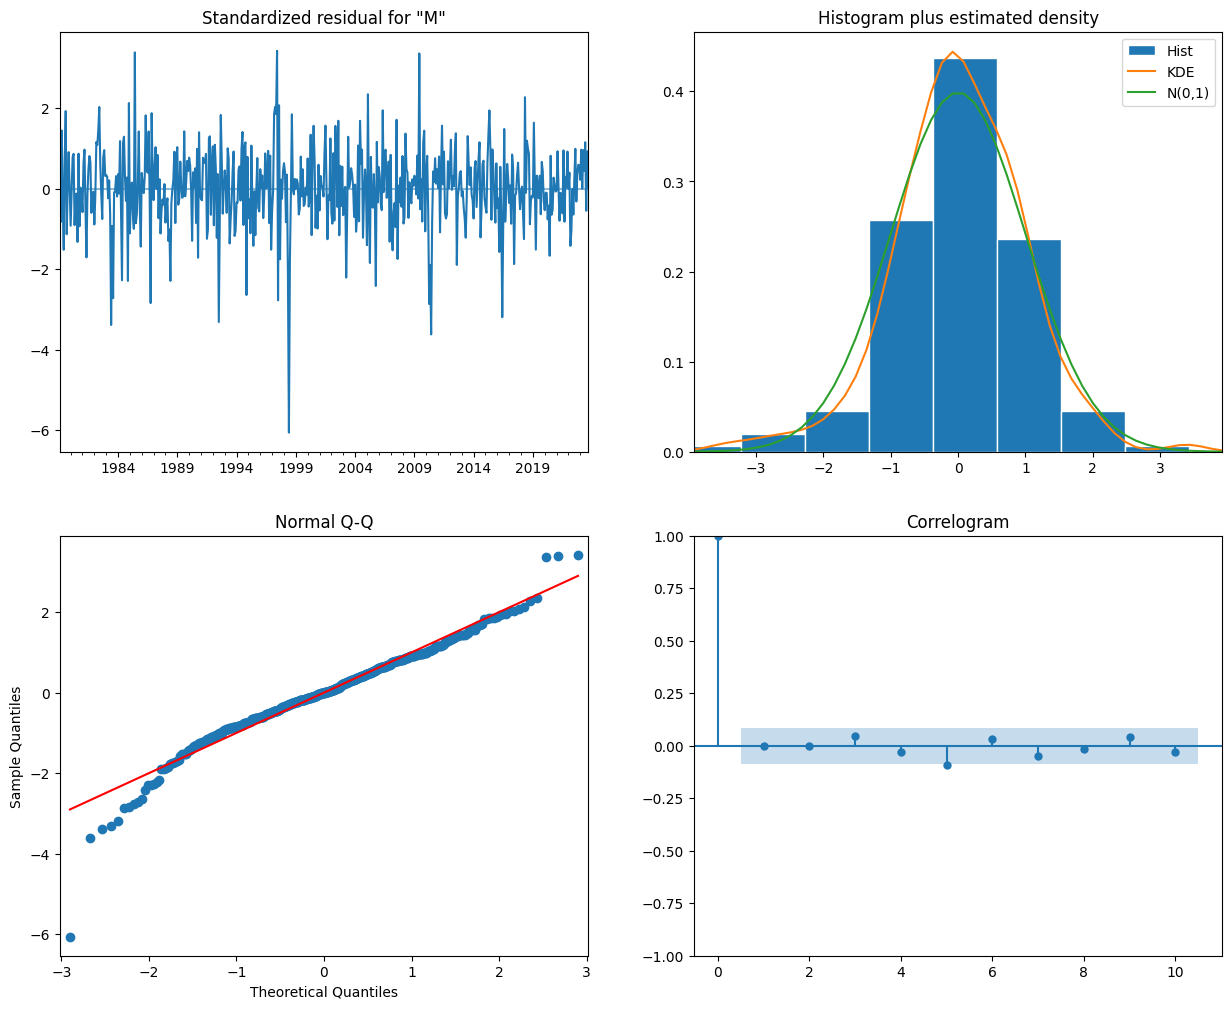

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -67.705
Date:                Thu, 16 Nov 2023   AIC                            145.409
Time:                        16:12:16   BIC                            166.830
Sample:                    01-01-1979   HQIC                           153.789
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1561      0.800      0.195      0.845      -1.412       1.724
ar.L2          0.1351      0.116      1.163      0.245      -0.093       0.363
ma.L1          0.3360      0.802      0.419      0.675      -1.235       1.907
ma.L2         -0.2461      0.491     -0.501      0.616      -1.208       0.716
sigma2         0.0753      0.003     24.068      0.000       0.069       0.081
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               281.44
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.61
Prob(H) (two-sided):                  0.11   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Fit an ARIMA(2,0,2) model
arima_model_212 = SARIMAX(enso_df['MEI'], order=(2, 1, 2))
arima_result_212 = arima_model_212.fit()

# Plot the diagnostics for the ARIMA(1,0,1) model
fig = arima_result_212.plot_diagnostics(figsize=(15, 12))
plt.savefig('../Plots/ARIMA_212.png')
plt.show()

# Return the summary of the new model as well
arima_result_101_summary = arima_result_212.summary()
display(arima_result_101_summary)


### ARIMAX(1,1,1) Continuation

We will now combine this model with a exogenous Fourier Decomposed variables to hopefully improve fit and add seasonality to our model.

- Add the seasonal Fourier components to the ARIMA(1,0,1) model as exogenous variables.
- Fit the ARIMAX model to the MEI time series data.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54243D-02    |proj g|=  1.32081D-01

At iterate    5    f=  7.93191D-02    |proj g|=  4.84421D-02

At iterate   10    f=  7.89535D-02    |proj g|=  8.15648D-04

At iterate   15    f=  7.89527D-02    |proj g|=  6.26495D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   2.341D-06   7.895D-02
  F =   7.8952703965760096E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


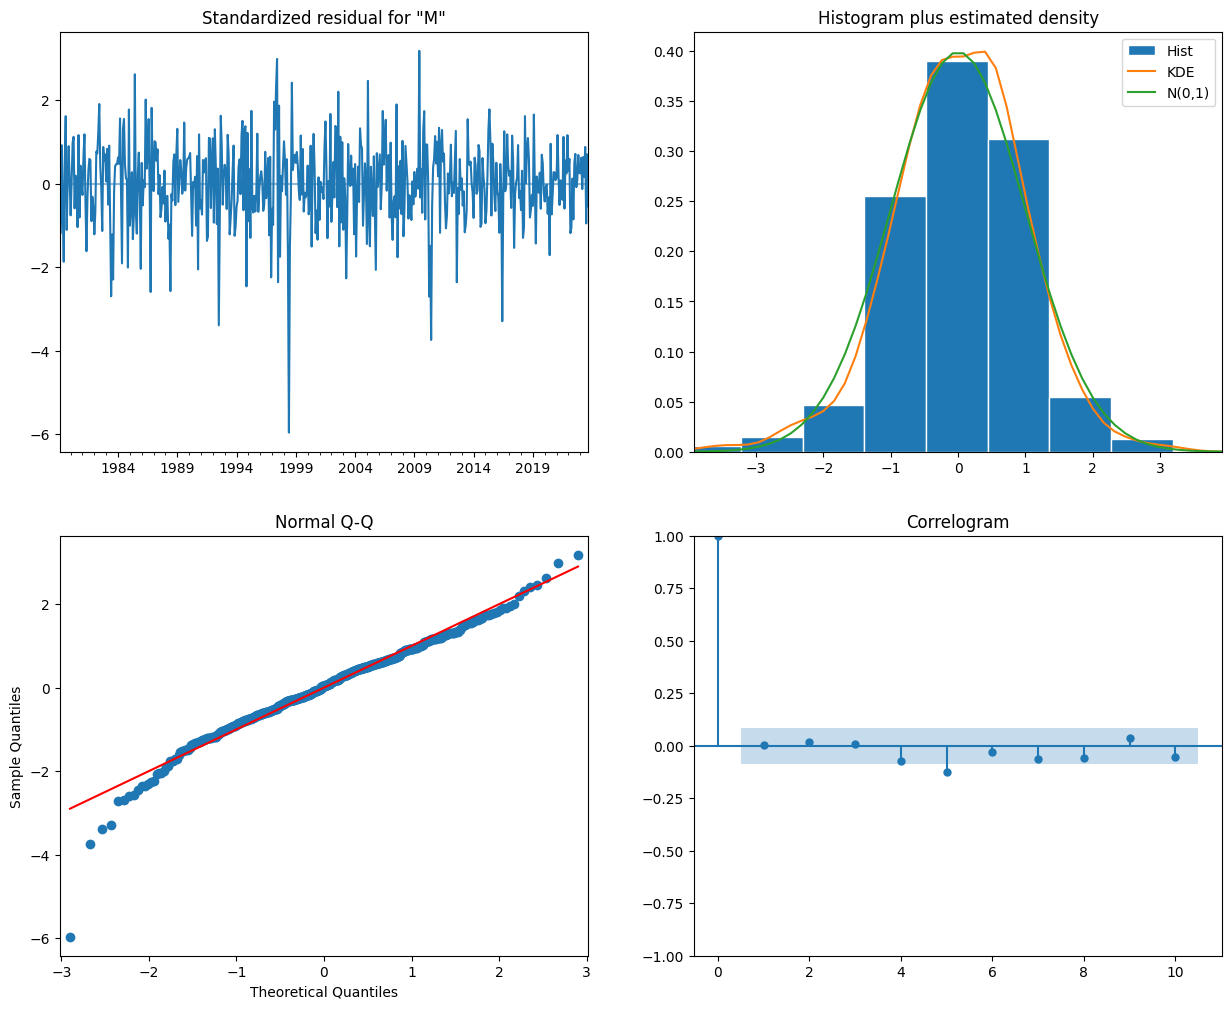

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -42.398
Date:                Thu, 16 Nov 2023   AIC                             92.795
Time:                        17:07:45   BIC                            109.932
Sample:                    01-01-1979   HQIC                            99.499
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0023      0.116      8.609      0.000       0.774       1.231
ar.L1         -0.2969      0.062     -4.772      0.000      -0.419      -0.175
ma.L1          0.7876      0.043     18.450      0.000       0.704       0.871
sigma2         0.0685      0.003     22.902      0.000       0.063       0.074
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               198.42
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.62
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Fit an ARIMAX model using the ARIMA(1,0,1) specification with the seasonal components
arimax_model = SARIMAX(enso_df['MEI'], exog=reconstructed_series, order=(1, 1, 1))
arimax_result = arimax_model.fit()

# Plot the diagnostics for the ARIMAX model
fig = arimax_result.plot_diagnostics(figsize=(15, 12)) # type: ignore
plt.savefig('../Plots/ARIMA_111_ex.png')
plt.show()

# Return the summary of the ARIMAX model as well
arimax_result_summary = arimax_result.summary() # type: ignore
display(arimax_result_summary)

ARIMAX(1,0,1) 
- AR and MA terms are significant
- Fourier components significant besides a couple
- LL improved from -36 to -58 compared to non exogenous ARIMA
- AIC/BIC lowered to 58 and 75
- L-B test no significant autocorrelation
- J-B test indicates that residuals are still not normally distributed but improvement over previous models
- ACF seems stable
- QQ shows still heavier tails.


### GARCH (not used)

A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model can be a valuable addition when there is evidence of conditional heteroskedasticity — that is, when the volatility (variance of the residuals) changes over time in a predictable pattern. It is particularly useful for financial time series where volatility clustering is common.

For the MEI.v2 time series, which is an environmental/climatic index, the use of a GARCH model is less common. However, if there is a reason to believe that there are volatility patterns in the MEI.v2 data that a GARCH model could capture, it might be worth exploring.

Before deciding to fit a GARCH model, we should look for signs of conditional heteroskedasticity in the residuals of the ARIMAX model. If we observe patterns or clusters of high and low volatility, a GARCH model could potentially improve the model by capturing this aspect of the data.

From the ARIMAX diagnostics, the residuals did not show clear signs of conditional heteroskedasticity, as the correlogram of squared standardized residuals did not indicate significant autocorrelations. This suggests that a GARCH model may not be necessary. Additionally, the p-value for the heteroskedasticity test was above 0.05, indicating no strong evidence of heteroskedasticity.

However, if you would like to test whether a GARCH model can improve the normality of the residuals, we can fit a GARCH(1,1) model to the residuals of the ARIMAX model and evaluate the results.

Would you like to proceed with fitting a GARCH model to the residuals?

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Perform Ljung-Box test on the residuals
ljung_box_result_resid = acorr_ljungbox(arimax_result.resid, lags=[4*12], return_df=True)

# Perform Ljung-Box test on the squared residuals
ljung_box_result_squared_resid = acorr_ljungbox(arimax_result.resid**2, lags=[4*12], return_df=True)

# Perform Engle's ARCH test on the residuals
arch_test = het_arch(arimax_result.resid, nlags=20)

# Create a rolling standard deviation plot for the residuals (volatility plot)
# rolling_window = 50  # Rolling window size
# rolling_std_resid = pd.Series(arimax_result.resid).rolling(window=rolling_window).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 14))

# Plot the squared residuals
axes[0].plot(arimax_result.resid ** 2)
axes[0].set_title('Squared Residuals')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Squared Residual Value')

# Plot ACF of residuals
plot_acf(arimax_result.resid, lags=50, ax=axes[1])
axes[1].set_title('ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')

plt.savefig('../Plots/ARIMA_111_ex_resid.png')
plt.show()
# Output the test results
arch_test

NameError: name 'arimax_result' is not defined

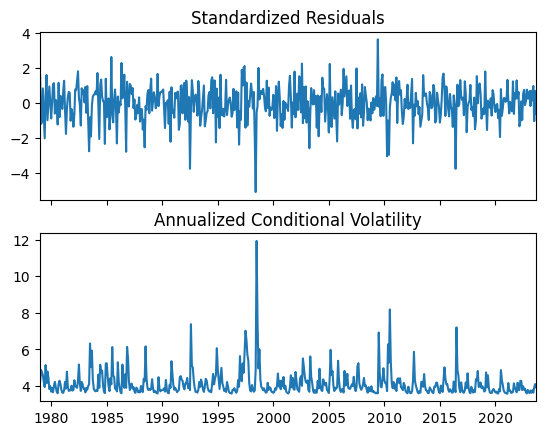

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -34.2369
Distribution:                  Normal   AIC:                           76.4738
Method:            Maximum Likelihood   BIC:                           93.6178
                                        No. Observations:                  537
Date:                Thu, Nov 16 2023   Df Residuals:                      536
Time:                        12:20:06   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.0808e-03  1.108e-02      0.639      0.523 [-1.464e-02,2.880e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0372  8.214e-03      4.528  5.947e-06 [2.109e-02,5.329e-02]
alpha[1]       0.2046      0.120      1.702  8.876e-02  [-3.101e-02,  0.440]
beta[1]        0.2661      0.140      1.903  5.699e-02  [-7.914e-03,  0.540]
============================================================================

Covariance estimator: robust
"""

Text(0.5, 1.0, 'Squared Residuals')

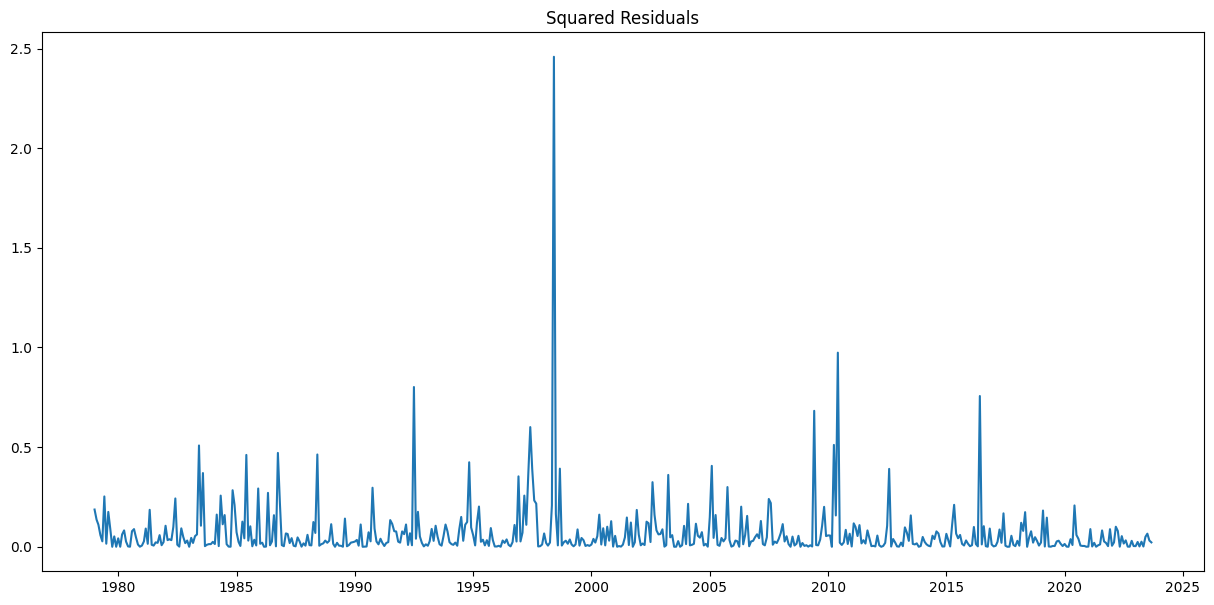

In [168]:
from arch import arch_model

# Extract the residuals from the ARIMAX model
arimax_residuals = arimax_result.resid

# Fit a GARCH(1,1) model to the residuals of the ARIMAX model
garch_model = arch_model(arimax_residuals, vol='Garch', p=1, q=1, rescale=False)
garch_result = garch_model.fit(update_freq=0, disp='off')

# Plot the GARCH model diagnostics
fig = garch_result.plot(annualize='D')
plt.show()

# Return the summary of the GARCH model as well
garch_result_summary = garch_result.summary()
display(garch_result_summary)

#Plot squared residuals
plt.figure(figsize=(15, 7))
plt.plot(garch_result.resid ** 2)
plt.title('Squared Residuals')

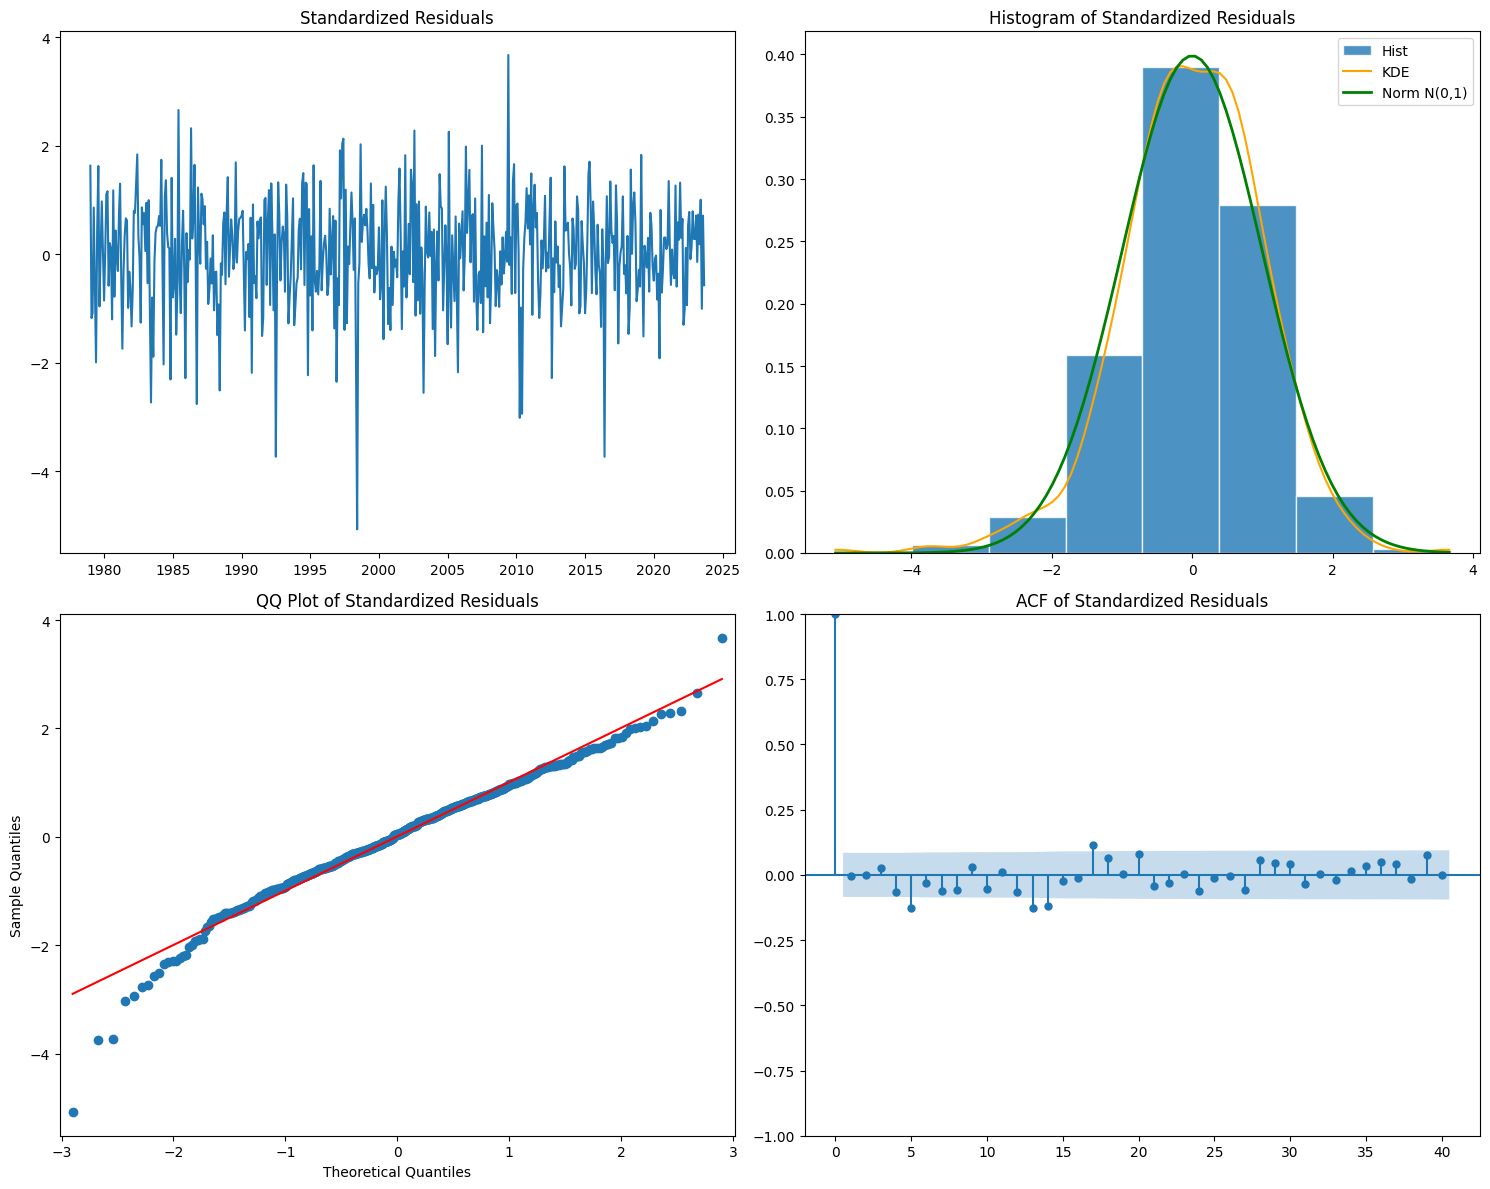

In [169]:
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import gaussian_kde


# Standardize the residuals
standardized_residuals = arimax_residuals / garch_result.conditional_volatility

# Normalized residuals for the histogram
normalized_residuals = (standardized_residuals - np.mean(standardized_residuals)) / np.std(standardized_residuals)
num_bins = 8
xmin, xmax = normalized_residuals.min(), normalized_residuals.max()
# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot standardized residuals
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized Residuals')


# Histogram of the standardized residuals with KDE
axs[0, 1].hist(normalized_residuals, bins=num_bins, density=True, alpha=0.8, label='Hist', linewidth= 1, edgecolor='white')
# Kernel Density Estimate (KDE) plot
kde = gaussian_kde(normalized_residuals)
x_grid = np.linspace(xmin, xmax, 100)
kde_pdf = kde(x_grid)
axs[0, 1].plot(x_grid, kde_pdf, '-', label='KDE', color = 'orange')
# Best fit line for normal distribution
p = norm.pdf(x_grid, np.mean(normalized_residuals), np.std(normalized_residuals))
axs[0, 1].plot(x_grid, p, '-', linewidth=2, color = 'green',label='Norm N(0,1)')
axs[0, 1].set_title('Histogram of Standardized Residuals')
axs[0, 1].legend()

# QQ plot for standardized residuals
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('QQ Plot of Standardized Residuals')

# ACF plot for standardized residuals
plot_acf(standardized_residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('ACF of Standardized Residuals')


plt.tight_layout()
plt.show()

In [170]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
# Conduct the Ljung-Box test on the residuals
lb_test_results = acorr_ljungbox(normalized_residuals, lags=[10], return_df=True)

# Conduct the Jarque-Bera test on the residuals
jb_test_stats = jarque_bera(normalized_residuals)

display(lb_test_results, jb_test_stats)

,lb_stat,lb_pvalue
10,18.014435,0.054721


(93.48853765389207,
 5.002901909256166e-21,
 -0.5158955568148075,
 4.764558234780222)

## Forecasting ARIMAX(1,1,1)

In [284]:
forecast_months = 4*12 # 4 years phase

# Extracting the dominant frequencies, amplitudes, and corresponding phases from the FFT
dominant_frequencies = fft_df_sorted.iloc[top_indices]['Frequency'].values
amplitudes = fft_df_sorted.iloc[top_indices]['Amplitude'].values

scaled_amplitudes = amplitudes / (N / 2)
phases = np.angle(yf[top_indices])

# Time vector for the forecast
time_vector_48 = np.arange(N, N + forecast_months) * T

# Function to construct the time series from the Fourier components
def construct_fourier_series(time_vector, frequencies, scaled_amplitudes, phases):
    time_series = np.zeros_like(time_vector, dtype=float)
    for i in range(len(frequencies)):
        frequency = frequencies[i]
        amplitude = scaled_amplitudes[i]
        phase = phases[i]
        time_series += amplitude * np.cos(2 * np.pi * frequency * time_vector + phase)
    return time_series

# Construct the 12-period and 60-period forecasts
forecast_48_periods = construct_fourier_series(time_vector_48, dominant_frequencies, scaled_amplitudes, phases)

# Check if the first 12 values of the 60-period forecast match the 12-period forecast
forecast_48_periods


array([-0.12259616, -0.02287234,  0.07648903,  0.17355987,  0.26648508,
        0.35352574,  0.43309897,  0.50381327,  0.5644984 ,  0.61422893,
        0.65234097,  0.67844146,  0.69241006,  0.69439356,  0.68479306,
        0.66424451,  0.63359333,  0.59386381,  0.54622456,  0.49195103,
        0.43238633,  0.36890169,  0.30285781,  0.23556822,  0.16826598,
        0.10207458,  0.0379839 , -0.023168  , -0.08070692, -0.13412804,
       -0.18309507, -0.22743308, -0.26711554, -0.30224629, -0.33303714,
       -0.35978213, -0.3828296 , -0.40255319, -0.419323  , -0.43347804,
       -0.44530129, -0.45499818, -0.46267961, -0.46835019, -0.47190215,
       -0.47311548, -0.47166412, -0.46712836])

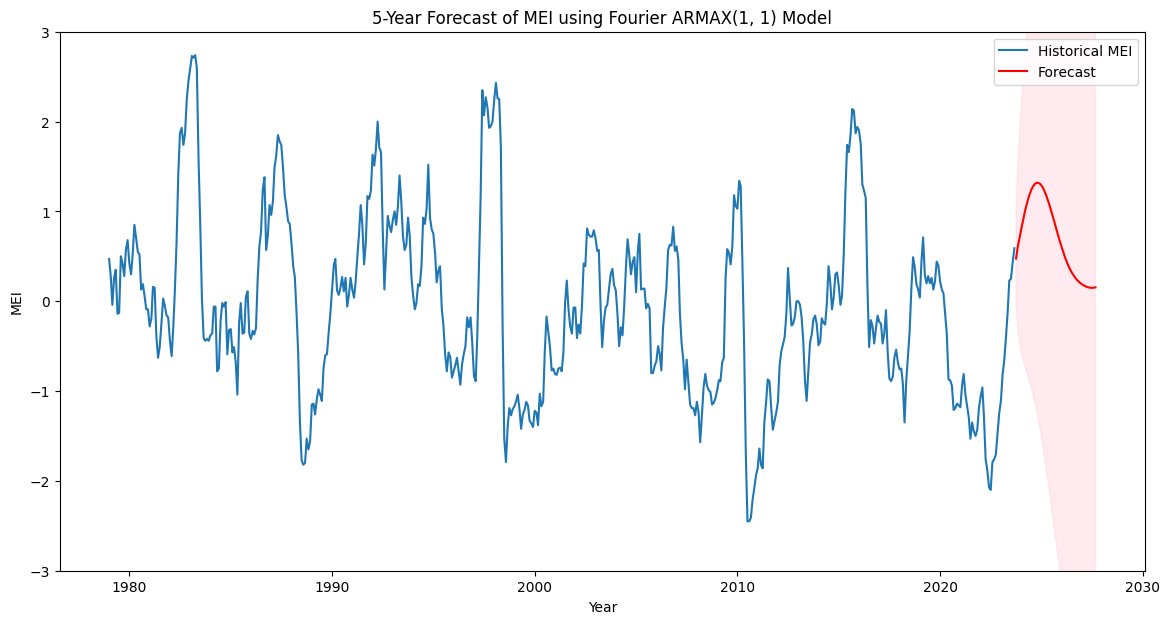

In [327]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming enso_df and arimax_result are defined and available here
# Get the last known value of the non-differenced series
last_known_value = enso_df['MEI'].iloc[-1]


forecast_steps = forecast_months  # 5 years * 12 months per year
forecast = arimax_result.get_forecast(steps=forecast_steps, exog = forecast_48_periods)
# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical MEI data along with the forecast and confidence intervals
plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(enso_df['MEI'], label='Historical MEI')

# Plot the forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.ylim(-3, 3)
plt.title('5-Year Forecast of MEI using Fourier ARMAX(1, 1) Model')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.savefig('../Plots/ARIMA_111_ex_forecast.png')
plt.show()



ARIMAX

The red line represents the forecasted MEI values.
The pink shaded area indicates the 95% confidence intervals for the forecast.

### GARCH Forecast (not used)

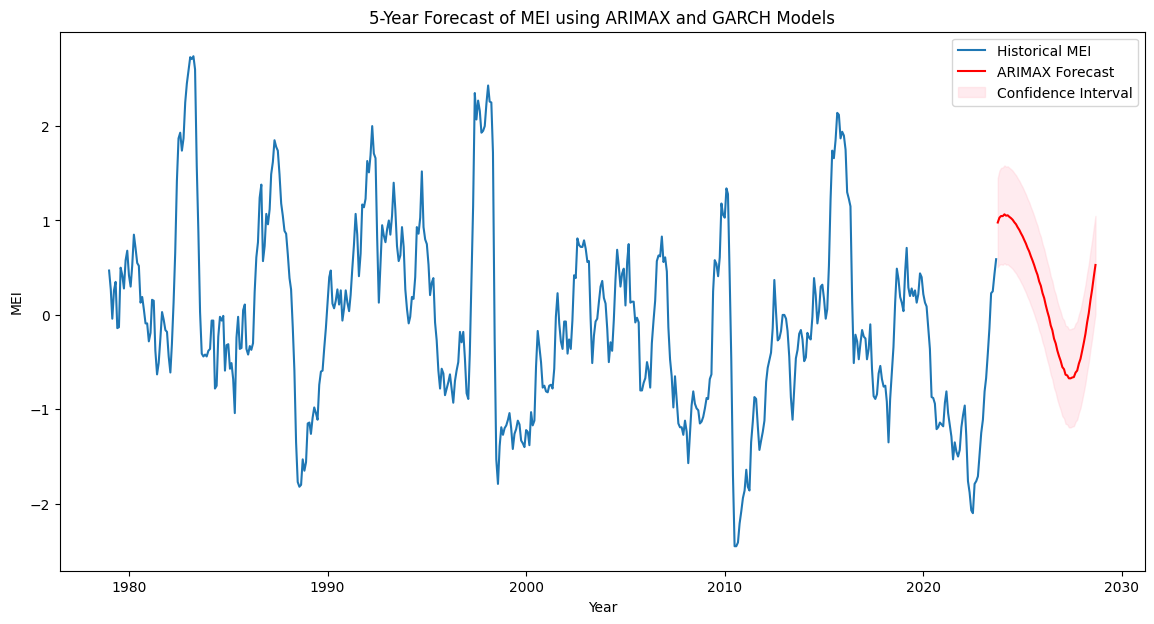

In [286]:
from scipy.stats import norm

# Forecast the next 5 years (60 months) using the ARIMAX model
forecast_steps = 60  # 5 years * 12 months per year
forecast = arimax_result.get_forecast(steps=forecast_steps, exog=forecasted_series_only)

# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#GARCH forecast
garch_forecast = garch_result.forecast(horizon=forecast_steps, reindex = False)
forecast_volatility = np.sqrt(garch_forecast.variance.dropna().values[-1])

z_score = norm.ppf(0.975)

forecast_lower = forecast_mean - (z_score * forecast_volatility)
forecast_upper = forecast_mean + (z_score * forecast_volatility)


# Plot the historical MEI data along with the forecast and confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(enso_df['MEI'], label='Historical MEI')
plt.plot(forecast_mean.index, forecast_mean, label='ARIMAX Forecast', color='red')
plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper, color='pink', alpha=0.3, label='Confidence Interval')
plt.title('5-Year Forecast of MEI using ARIMAX and GARCH Models')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.show()


ARIMAX-GARCH

The red line represents the forecasted MEI values.
The pink shaded area indicates the 95% confidence intervals for the forecast.

### Phase Scenario's

Simulate different phases using forecasted values as baseline.

- Heavier -> increase by a certain percentage or add constant
- Longer -> Extend duration of positive values before going back to La Niña
   - To add realism we incorporate a random variation to the forecasts


### Heavier

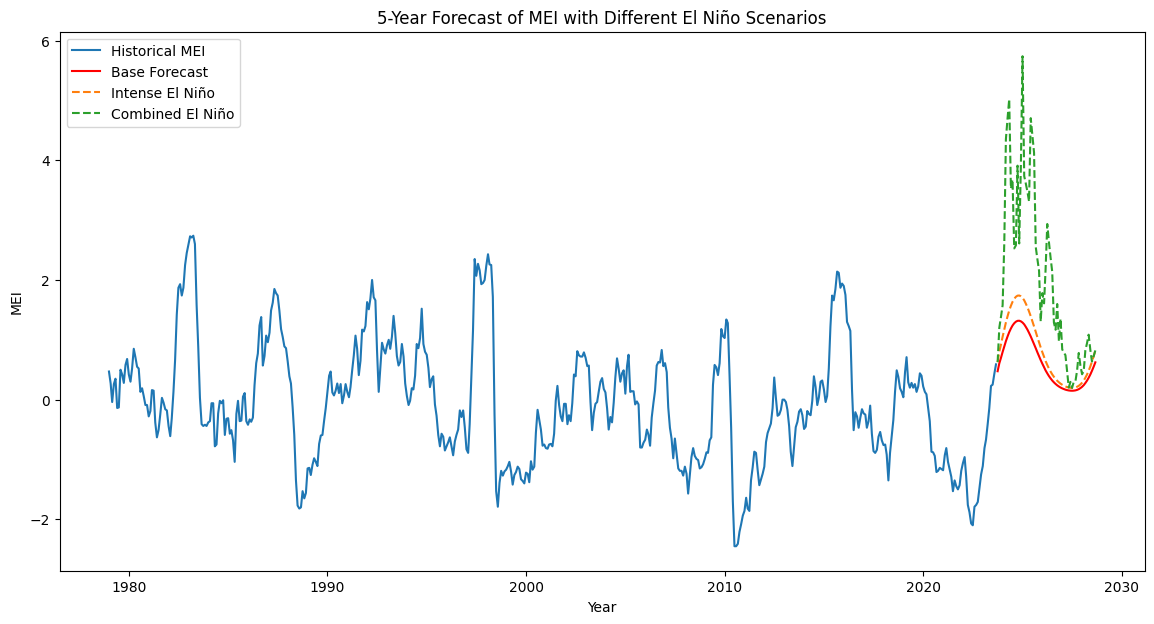

In [235]:
import random
#set seed
random.seed(42)
# Define the parameters for the scenarios
intensity_factor = 1.5  # Increase intensity by 50%
duration_extension = 6  # Extend the phase by 6 months

# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=forecast_mean.index)

# Scenario 1: Intense El Niño
scenarios_df['Intense El Niño'] = forecast_mean * (1 + random.uniform(0, intensity_factor - 1))

# Scenario 2: Long El Niño

# Scenario 3: Combination of intense and long El Niño
scenarios_df['Combined El Niño'] = scenarios_df['Intense El Niño'].copy()
for i in range(len(scenarios_df['Combined El Niño']) - duration_extension):
    if scenarios_df['Combined El Niño'].iloc[i] > 0:  # If we're in an El Niño phase
        extension = random.uniform(0, duration_extension)
        scenarios_df['Combined El Niño'].iloc[i:i+int(extension)] *= intensity_factor


# Plot the scenarios alongside the historical data and the base forecast
plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(enso_df['MEI'], label='Historical MEI')

# Plot the base forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Base Forecast', color='red')

# Plot the scenarios
plt.plot(scenarios_df.index, scenarios_df['Intense El Niño'], label='Intense El Niño', linestyle='--')
# plt.plot(scenarios_df.index, scenarios_df['Long El Niño'], label='Long El Niño', linestyle='--')
plt.plot(scenarios_df.index, scenarios_df['Combined El Niño'], label='Combined El Niño', linestyle='--')

plt.title('5-Year Forecast of MEI with Different El Niño Scenarios')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.show()


The scenarios are generated with some randomness to reflect natural variability, and as you can see, they vary in terms of both intensity and duration compared to the base forecast.

These simulations provide a visual representation of how future El Niño events could differ from the typical patterns observed in the past, assuming various changes in intensity and duration. Keep in mind that actual future conditions may be influenced by many other factors not included in this model.​

### Combined Scenario's (This will be used)

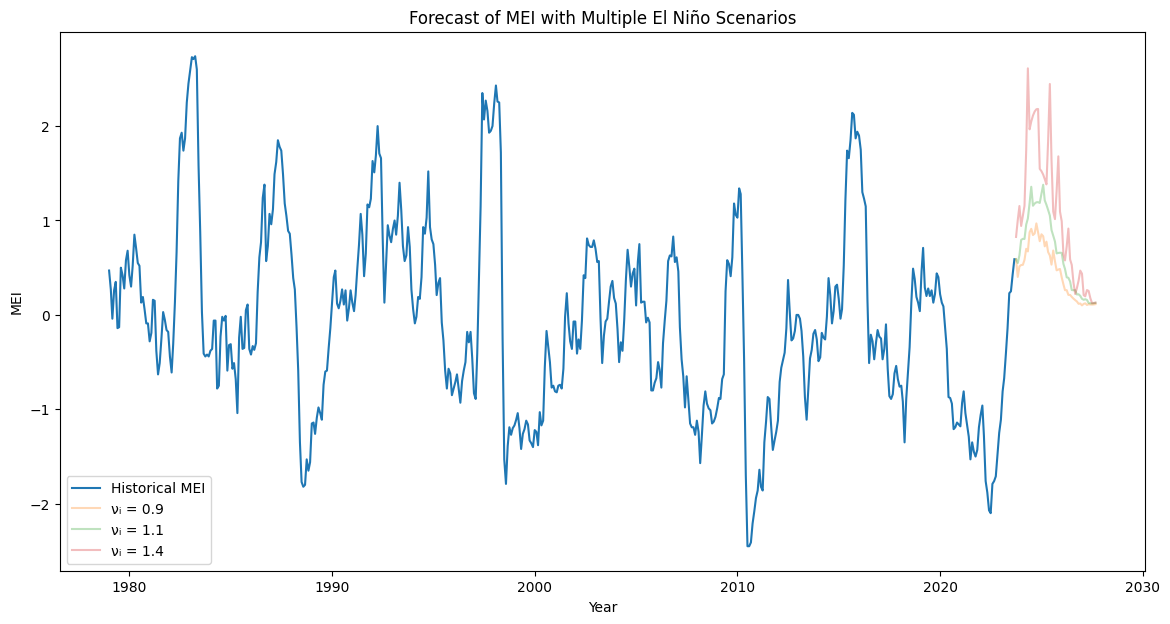

In [326]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set the random seed for reproducibility
random.seed(42)

# Define the range of intensity factors
intensity_factors = [0.9, 1.1, 1.4]
# intensity_factors = np.arange(1.2, 1.6, 0.1)


# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=forecast_mean.index)
duration_extension = 4
# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"νᵢ = {factor:.1f}"
    scenarios_df[scenario_name] = forecast_mean * (0.8 + random.uniform(0, factor - 1))
    
    for i in range(len(scenarios_df[scenario_name]) - duration_extension):
        if i == 0:
            scenarios_df[scenario_name].iloc[i] = enso_df['MEI'].iloc[-1]

        if scenarios_df[scenario_name].iloc[i] > 0:
            extension = random.uniform(0, duration_extension)
            scenarios_df[scenario_name].iloc[i:i+int(extension)] *= factor



# Plot the historical data and the base forecast
plt.figure(figsize=(14, 7))
plt.plot(enso_df['MEI'], label='Historical MEI')
# plt.plot(forecast_mean.index, forecast_mean, label='Base Forecast', color='red', alpha = 0.8)

# Plot each of the intense El Niño scenarios
for column in scenarios_df.columns:
    plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha = 0.3)

# Add title, labels, and legend
plt.title('Forecast of MEI with Multiple El Niño Scenarios')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.savefig('../Plots/ARIMA_111_scen_3.png')
plt.show()


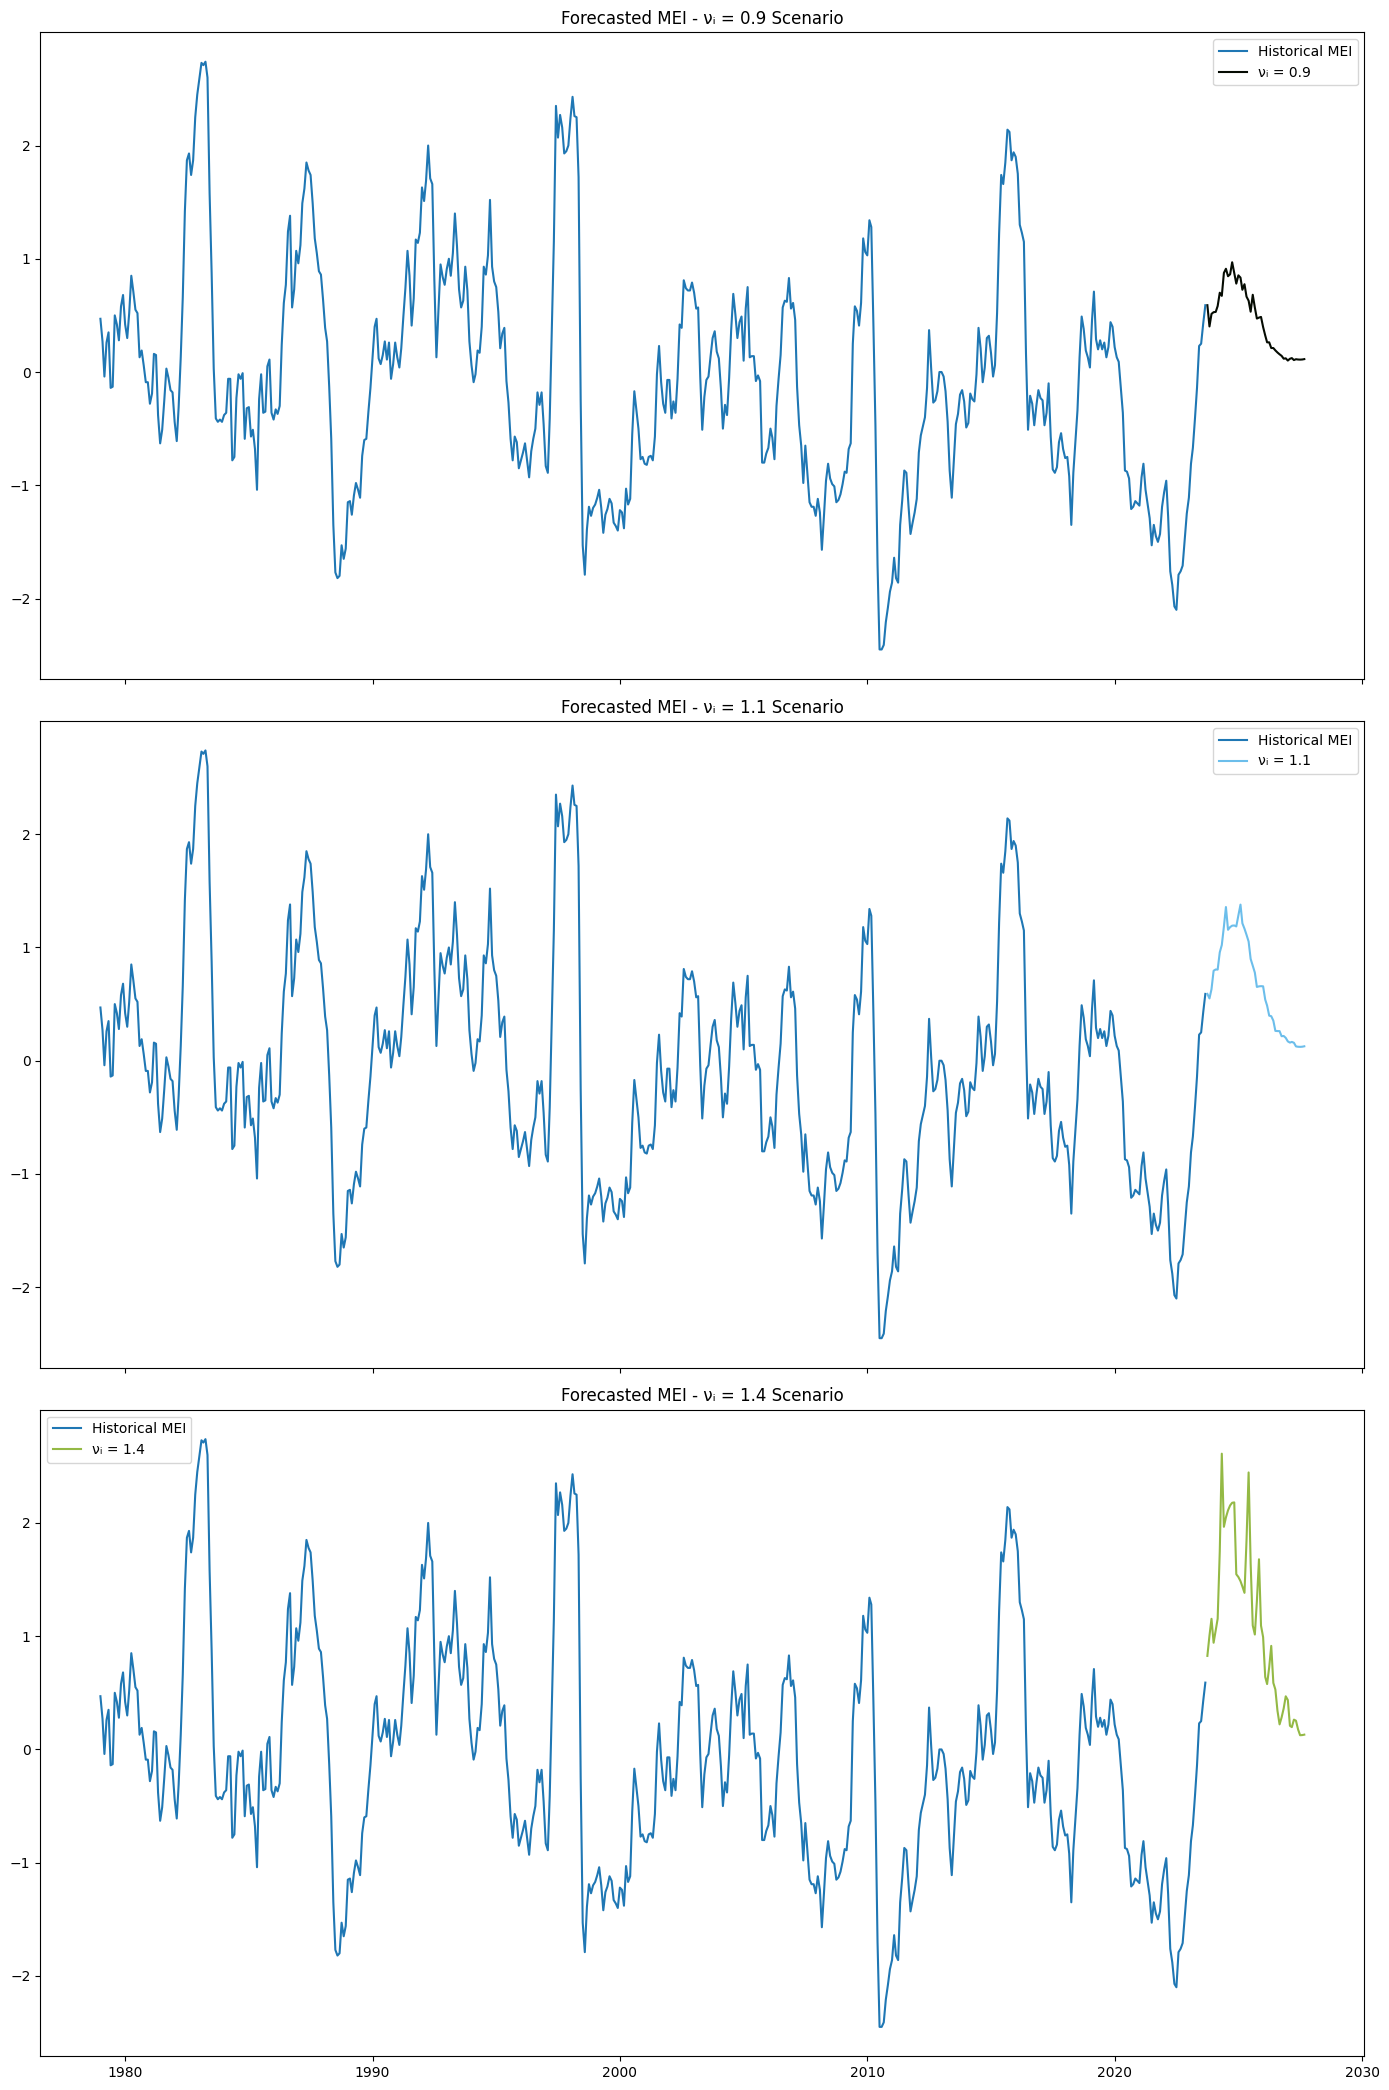

In [334]:
fig, axs = plt.subplots(len(scenarios_df.columns), 1, figsize=(14, 7 * (len(scenarios_df.columns))), sharex=True)

# Plot each scenario
for i, column in enumerate(scenarios_df.columns, start=0):
    axs[i].plot(enso_df.index, enso_df['MEI'], label='Historical MEI')
    axs[i].plot(scenarios_df.index, scenarios_df[column], label=column, color=np.random.rand(3,))
    axs[i].set_title(f'Forecasted MEI - {column} Scenario')
    axs[i].legend()

plt.tight_layout()
plt.savefig('../Plots/ARIMA_111_scen_3_subplot.png')
plt.show()

### Try Brownian Moition (Not Used)

In [133]:
# def generate_brownian_scenarios(base_forecast, drift_rate, volatility, num_scenarios=1):
#     scenarios_df = pd.DataFrame(index=base_forecast.index)
#     for i in range(num_scenarios):
#         scenario = base_forecast.copy()     
#         # Apply Brownian motion
#         for t in range(1, len(scenario)):
#             drift = drift_rate[i] * scenario.iloc[t - 1]
#             shock = np.random.normal(0, volatility)
#             scenario.iloc[t] = scenario.iloc[t] + drift + shock
    
#         scenarios_df[f'Scenario_{i + 1}'] = scenario
    
#     return scenarios_df

## Save predictions/scenario's/simulations

In [134]:
#Extract Predicted values
forecast_dates = forecast_mean.index
forecast_values = forecast_mean.values


# Create a dictionary to hold dates and values for each scenario
scenarios_data = {}

for scenario in scenarios_df.columns:
    # Extract the MEI values for the scenario
    scenario_values = scenarios_df[scenario].values
    # Store the dates and values in the dictionary
    scenarios_data[scenario] = {
        'dates': forecast_dates,
        'values': scenario_values
    }
#Create one dataframe for all scenarios with key as column name
scenarios_df = pd.DataFrame(scenarios_data)
scenarios_df.head()

,νᵢ = 1.1,νᵢ = 1.3,νᵢ = 1.5
dates,"DatetimeIndex(['2023-10-01', '2023-11-01', '20...","DatetimeIndex(['2023-10-01', '2023-11-01', '20...","DatetimeIndex(['2023-10-01', '2023-11-01', '20..."
values,"[0.5803731015811068, 0.7556666691869101, 0.799...","[0.7978163346253743, 1.2276556921070338, 1.688...","[0.9650617908761023, 1.142313808893195, 1.2084..."


In [135]:
pd.DataFrame(forecast_dates, forecast_values).head()

,0
0.671773,2023-10-01
0.795157,2023-11-01
0.841175,2023-12-01
0.914008,2024-01-01
0.961603,2024-02-01
